In [1]:
import numpy as np
import pandas as pd
import os
import glob
import itertools
import scanpy as sc
import natsort
import json

from scroutines import basicu

import seaborn as sns

In [2]:
# ddir = '/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/cheng21_cell_scrna/organized'
# outdir = '/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/results/GABAARs'
# !mkdir -p $outdir

In [3]:
def get_cond_from_biosample(sample):
    """
    """
    cond = sample[:-1]
    if not cond.endswith('DR'): 
        cond = cond+'NR'
        
    return cond

In [4]:
%%time
f = '../../data/v1_multiome/L23_allmultiome_proc_P6toP21_NRDR.h5ad'
adata_l23 = sc.read(f)
adata_l23.obs['cond'] = adata_l23.obs['sample'].apply(lambda x: get_cond_from_biosample(x))
adata_l23

CPU times: user 570 ms, sys: 4.06 s, total: 4.63 s
Wall time: 53.5 s


AnnData object with n_obs × n_vars = 38539 × 16509
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Age', 'Doublet', 'Doublet.Score', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'Type', 'Subclass', 'Class', 'Sample', 'total_counts', 'pct_counts_mt', 'n_genes_by_counts', 'total_counts_mt', 'Doublet.', 'Study', 'Type_leiden', 'time', 'cond', 'easitype', 'cond_order'
    var: 'features'
    obsm: 'pca_p17on', 'pca_p8'
    layers: 'norm'

In [5]:
%%time
f = '/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/v1_multiome/superdupermegaRNA_hasraw.h5ad'
adata_all = sc.read(f)
adata_all = adata_all[adata_all.obs['Study']=='2023 Multiome']
adata_all = adata_all[adata_all.obs['Subclass']=='L2/3']
genes_mul = adata_all.var.index.values
adata_all

CPU times: user 5.51 s, sys: 20.8 s, total: 26.3 s
Wall time: 3min 39s


View of AnnData object with n_obs × n_vars = 38539 × 16572
    obs: 'Age', 'Doublet', 'Doublet Score', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'Type', 'Subclass', 'Class', 'Sample', 'total_counts', 'pct_counts_mt', 'n_genes_by_counts', 'total_counts_mt', 'Doublet?', 'Study', 'Type_leiden'
    var: 'feature_types'

In [6]:
adata_all.obs['cond'] = adata_all.obs['Sample'].apply(lambda x: get_cond_from_biosample(x))
adata_all.obs['biosample'] = adata_all.obs['Sample']

/tmp/ipykernel_48072/2933899518.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_all.obs['cond'] = adata_all.obs['Sample'].apply(lambda x: get_cond_from_biosample(x))


In [7]:
unq_samples = natsort.natsorted(adata_all.obs['Sample'].unique())
print(len(unq_samples))
print(unq_samples) 

unq_conds   = natsort.natsorted(adata_all.obs['cond'].unique())
nf = len(unq_conds)
print(nf)
print(unq_conds)

25
['P6a', 'P6b', 'P6c', 'P8a', 'P8b', 'P8c', 'P10a', 'P10b', 'P12DRa', 'P12DRb', 'P12a', 'P12b', 'P12c', 'P14DRa', 'P14DRb', 'P14a', 'P14b', 'P17DRa', 'P17DRb', 'P17a', 'P17b', 'P21DRa', 'P21DRb', 'P21a', 'P21b']
11
['P6NR', 'P8NR', 'P10NR', 'P12DR', 'P12NR', 'P14DR', 'P14NR', 'P17DR', 'P17NR', 'P21DR', 'P21NR']


In [8]:
# unq_types = np.array(['A', 'AB', 'B', 'BC', 'C'])
# print(unq_types)
# min_type = adata_all[adata_all.obs['cond']=='P21NR'].obs.groupby(['Subclass', 'Sample']).size().unstack().min(axis=1)
# unq_types = min_type[min_type > 10].index.astype(str).values
# unq_types

In [9]:
### check size

for i, cond_name in enumerate(unq_conds):
    print(cond_name)
    
    adata = adata_all[adata_all.obs['cond']==cond_name]
    
    
    adata_l23_sub = adata_l23[adata_l23.obs['cond']==cond_name]
    
    # check cells
    cells_overlap = np.intersect1d(adata_l23_sub.obs.index.values, adata.obs.index.values)
    assert len(cells_overlap) ==  adata_l23_sub.shape[0]
    
    # check sample
    sample_lbls = adata.obs['biosample'].values
    unq_samples = np.unique(sample_lbls)

    # check size
    nr, ng =  len(unq_samples), len(adata.var)  #  rep, subclass, gene 
    print(nr, ng)
    

P6NR
3 16572
P8NR
3 16572
P10NR
2 16572
P12DR
2 16572
P12NR
3 16572
P14DR
2 16572
P14NR
2 16572
P17DR
2 16572
P17NR
2 16572
P21DR
2 16572
P21NR
2 16572


In [10]:
nc = 10
nf, nr, nc, ng

(11, 2, 10, 16572)

In [11]:
adata_l23.obs['cond'].unique()
# cond_name

array(['P6NR', 'P8NR', 'P10NR', 'P12NR', 'P12DR', 'P14NR', 'P14DR',
       'P17NR', 'P17DR', 'P21NR', 'P21DR'], dtype=object)

In [12]:
### read in the file and prep

nr = 3 # dummy for some
bigtensor = np.zeros((nf, nr, nc, ng))

for i, cond_name in enumerate(unq_conds):
    print(cond_name)
    
    adata = adata_all[adata_all.obs['cond']==cond_name]
    
    # check cells
    adata_l23_sub = adata_l23[adata_l23.obs['cond']==cond_name]
    cells_overlap = np.intersect1d(adata_l23_sub.obs.index.values, adata.obs.index.values)
    assert len(cells_overlap) ==  adata_l23_sub.shape[0]
    
    # check cells and genes
    adata = adata[adata_l23_sub.obs.index, genes_mul]
    adata.obsm['pca_p17on'] = adata_l23_sub.obsm['pca_p17on']
    print(adata.shape)
    
    ### sum over counts 
    # by sample
    sample_lbls = adata.obs['biosample'].values
    unq_samples = np.unique(sample_lbls)

    # by type -- cut into nc=5 equal bins
    x = adata.obsm['pca_p17on'][...,0]
    type_lbls = pd.qcut(x, nc, labels=np.arange(nc)).astype(int)
    unq_types = np.unique(type_lbls)

        
#     ### sum over counts 
#     # by sample
#     sample_lbls = adata.obs['biosample'].values
#     unq_samples = np.unique(sample_lbls)

#     # by type -- cut into nc=5 equal bins
#     x = adata.obsm['pca_p17on'][...,0]
#     type_lbls = pd.qcut(x, nc, labels=np.arange(nc)).astype(int)
#     unq_types = np.unique(type_lbls)
    

    nr, nc, ng =  len(unq_samples), len(unq_types), len(adata.var)  #  rep, subclass, gene 

    for j, this_samp in enumerate(unq_samples):
        for k, this_type in enumerate(unq_types):
            selector = ((sample_lbls==this_samp) & (type_lbls==this_type))
            bigtensor[i,j,k] = np.sum(np.array(adata[selector].X.todense()), axis=0) # raw reads sum over all cells
    
    if j < 2:
        bigtensor[i,2] = np.nan 
            
### CPM  - per cond, sample and subclass
# normalize it as log2(1+CPM)
bigtensor = (bigtensor/np.sum(bigtensor, axis=-1, keepdims=True))*1e6
bigtensor = np.log2(1+bigtensor) 

P6NR
(6612, 16572)
P8NR
(5137, 16572)
P10NR
(3135, 16572)
P12DR
(2782, 16572)
P12NR
(3793, 16572)
P14DR
(2348, 16572)
P14NR
(3048, 16572)
P17DR
(2760, 16572)
P17NR
(2455, 16572)
P21DR
(4256, 16572)
P21NR
(2213, 16572)


In [13]:
output = '/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/v1_multiome/res/bigtensor_l23type_10bin.npy' 
np.save(output, bigtensor)

In [15]:
output_meta = '/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/v1_multiome/res/bigtensor_l23type_10bin.json' 
meta = {
    'size': bigtensor.shape,
    
    'dim0': list(unq_conds),
    'dim1': ['a', 'b', 'c'],
    'dim2': list(np.arange(10).astype(str)), #['A', 'AB', 'B', 'BC', 'C'], #list(unq_types.astype(str)),
    'dim3': list(genes_mul),
}

with open(output_meta, 'w') as fp:
    json.dump(meta, fp)

In [16]:
bigtensor = np.load(output)
bigtensor.shape

(11, 3, 10, 16572)

In [17]:
with open(output_meta, 'r') as fp:
    meta = json.load(fp)

# plot

In [18]:
import matplotlib.pyplot as plt
from scroutines.config_plots import *

In [19]:
class Bigtensor():
    def __init__(self, bigtensor, meta):
        
        self.palette = {
            'NR': 'C1', 
            'DR': 'k',
            'DL': 'C2', 
        }

        self.anno_marker_dict = {
            'NR': 'o',
            'DR': 's',
            'DL': '^',
        }
        
        self.bigtensor = bigtensor
        self.nf, self.nr, self.nc, self.ng = meta['size']
        self.conds = np.array(meta['dim0'])
        self.reps  = np.array(meta['dim1'])
        self.types = np.array(meta['dim2'])
        self.genes = np.array(meta['dim3'])

        self.conds_time = np.array([int(cond[1:-2]) for cond in self.conds])
        self.conds_anno = np.array([cond[-2:] for cond in self.conds])
        self.conds_color = pd.Series(self.palette).loc[self.conds_anno].values 
        
        return
    
    def plot_one(self, ax, selected_type, selected_gene, annotate=True):
        """
        """
        type_idx = basicu.get_index_from_array(self.types, [selected_type])[0]
        gene_idx = basicu.get_index_from_array(self.genes, [selected_gene])[0]
                
        assert np.all(type_idx != -1)
        assert np.all(gene_idx != -1)

        vals = self.bigtensor[:,:,type_idx, gene_idx] # cond by rep
        vals_mean = np.nanmean(vals, axis=1)


        ax.set_title(f'{selected_gene} in {selected_type}')
        for anno in ['NR', 'DR', 'DL']:
            marker = self.anno_marker_dict[anno]
            sel = self.conds_anno == anno
            if sel.sum() > 0:
                
                if anno == 'NR':
                    ax.set_xticks(self.conds_time[sel])
                    ax.plot(self.conds_time[sel], vals_mean[sel], '-k')

                ax.scatter(np.repeat(self.conds_time[sel], self.nr), vals[sel].reshape(-1,), 
                           color='k',
                           facecolors='none',
                           marker=marker,
                           label=anno,
                          )

        sns.despine(ax=ax)
        ax.grid(axis='x')

        if annotate:
            handles, labels = ax.get_legend_handles_labels()
            unique_labels = dict(zip(labels, handles))
            ax.legend(unique_labels.values(), unique_labels.keys(), fontsize=12) # , bbox_to_anchor=(1,1))

            ax.set_xlabel('Postnatal day (P)')
            ax.set_ylabel('log2(CPM+1)')
        

In [20]:
bo = Bigtensor(bigtensor, meta)

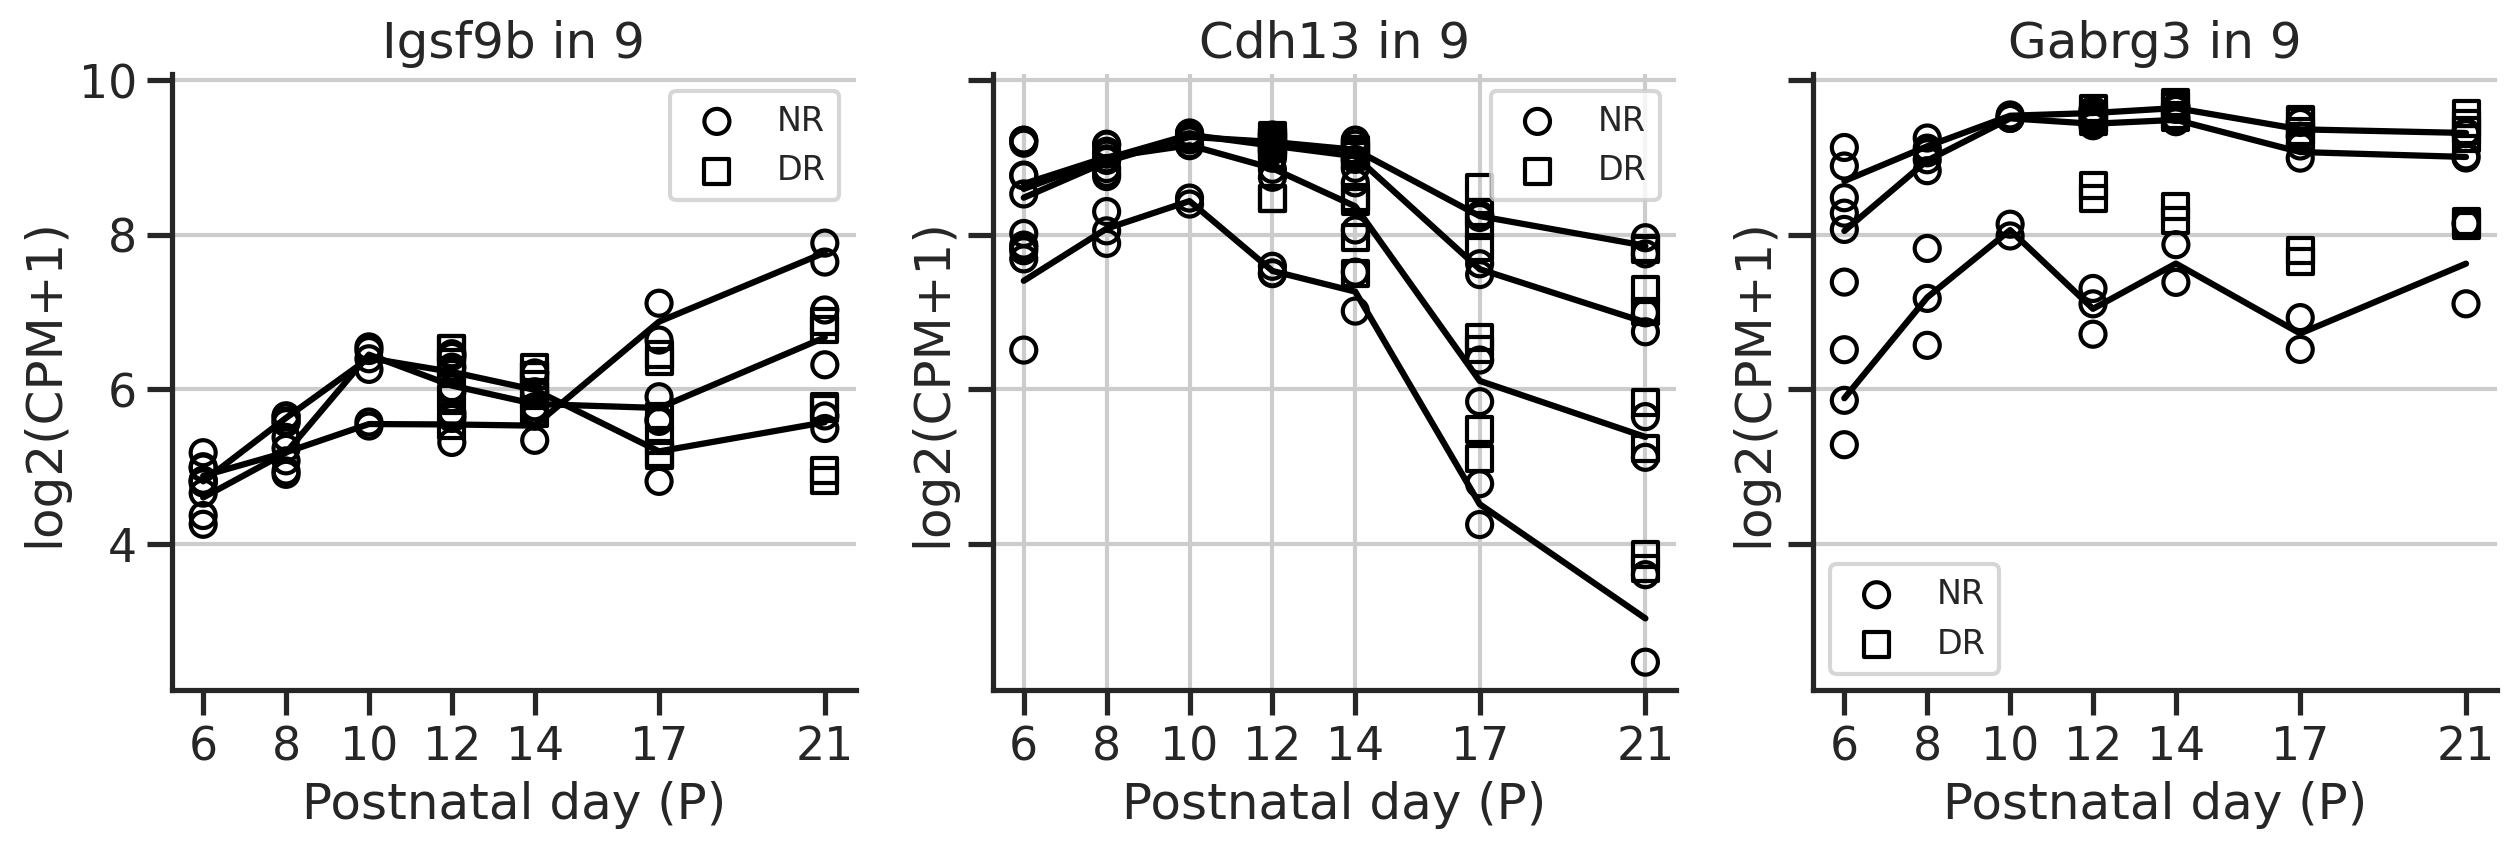

In [23]:
fig, axs = plt.subplots(1,3,figsize=(3*5,1*4), sharex=True, sharey=True)
ax = axs[0]
bo.plot_one(ax, '1', 'Igsf9b')
bo.plot_one(ax, '5', 'Igsf9b', annotate=False)
bo.plot_one(ax, '9', 'Igsf9b', annotate=False)
ax = axs[1]
bo.plot_one(ax, '1', 'Cdh13')
bo.plot_one(ax, '2', 'Cdh13', annotate=False)
bo.plot_one(ax, '5', 'Cdh13', annotate=False)
bo.plot_one(ax, '9', 'Cdh13', annotate=False)
ax = axs[2]
bo.plot_one(ax, '1', 'Gabrg3')
bo.plot_one(ax, '5', 'Gabrg3', annotate=False)
bo.plot_one(ax, '9', 'Gabrg3', annotate=False)